# Predict the Sun Hours by Decision Tree

## Import Modules

In [204]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

RANDOM_SEED = 9


## Import Data

Below is the [Daily Weather Observations of Sydney, New South Wales between Aug 2015 and Aug 2016](http://www.bom.gov.au/climate/dwo/IDCJDW0210.shtml).

In [205]:
data = pd.read_csv('./asset/Daily_Weather_Observations.csv', sep=',')
print(data.shape)
data.head()

(397, 24)


,Year,Month,Date,Day,Temps_min,Temps_max,Rain,Evap,Sun_hours,Max_wind_dir,...,CLD_at_9am,Wind_dir_at_9am,Wind_spd_at_9am,MSLP_at_9am,Temp_at_3pm,RH_at_3pm,CLD_at_3pm,Wind_dir_at_3pm,Wind_spd_at_3pm,MSLP_at_3pm
0,2015,8,1,Sa,9.4,22.3,0.0,3.4,9.2,WNW,...,6.0,NW,15,1018.6,20.7,28,6,NW,28,1015.6
1,2015,8,2,Su,14.3,24.7,0.0,5.4,7.8,WNW,...,5.0,WNW,9,1015.1,23.8,30,5,NW,20,1010.4
2,2015,8,3,Mo,8.4,19.4,0.0,5.4,10.1,WSW,...,1.0,WNW,20,1015.2,19.0,29,1,WSW,17,1013.7
3,2015,8,4,Tu,8.3,15.1,0.0,3.8,4.6,WSW,...,7.0,W,19,1023.0,14.4,42,4,SSE,2,1018.9
4,2015,8,5,We,5.0,14.2,0.0,0.6,4.8,W,...,6.0,WNW,20,1014.5,13.0,46,6,WNW,19,1010.3


### Column Meanings
| Heading         | Meaning                                                  | Units               |
|-----------------|----------------------------------------------------------|---------------------|
| Day             | Day of the week                                          | first two letters   |
| Temps_min       | Minimum temperature in the 24 hours to 9am.              | degrees Celsius     |
| Temps_max       | Maximum temperature in the 24 hours from 9am.            | degrees Celsius     |
| Rain            | Precipitation (rainfall) in the 24 hours to 9am.         | millimetres         |
| Evap            | Class A pan evaporation in the 24 hours to 9am           | millimetres         |
| Sun_hours       | Bright sunshine in the 24 hours to midnight              | hours               |
| Max_wind_dir    | Direction of strongest gust in the 24 hours to midnight  | 16 compass points   |
| Max_wind_spd    | Speed of strongest wind gust in the 24 hours to midnight | kilometres per hour |
| Max_wind_time   | Time of strongest wind gust                              | local time hh:mm    |
| Temp_at_9am     | Temperature at 9 am                                      | degrees Celsius     |
| RH_at_9am       | Relative humidity at 9 am                                | percent             |
| CLD_at_9am      | Fraction of sky obscured by cloud at 9 am                | eighths             |
| Wind_dir_at_9am | Wind direction averaged over 10 minutes prior to 9 am    | compass points      |
| Wind_spd_at_9am | Wind speed averaged over 10 minutes prior to 9 am        | kilometres per hour |
| MSLP_at_9am     | Atmospheric pressure reduced to mean sea level at 9 am   | hectopascals        |
| Temp_at_3pm     | Temperature at 3 pm                                      | degrees Celsius     |
| RH_at_3pm       | Relative humidity at 3 pm                                | percent             |
| CLD_at_3pm      | Fraction of sky obscured by cloud at 3 pm                | eighths             |
| Wind_dir_at_3pm | Wind direction averaged over 10 minutes prior to 3 pm    | compass points      |
| Wind_spd_at_3pm | Wind speed averaged over 10 minutes prior to 3 pm        | kilometres per hour |
| MSLP_at_3pm     | Atmospheric pressure reduced to mean sea level at 3 pm   | hectopascals        |

We have noticed that the *Sun_hours* values are missing in some rows. We want to predict these missing *Sun_hours* values.

We firstly seperate those rows with missing Sun_hours from the original dataset.

In [206]:
data_missing_sun_hours = data[pd.isnull(data['Sun_hours'])]
data_missing_sun_hours

,Year,Month,Date,Day,Temps_min,Temps_max,Rain,Evap,Sun_hours,Max_wind_dir,...,CLD_at_9am,Wind_dir_at_9am,Wind_spd_at_9am,MSLP_at_9am,Temp_at_3pm,RH_at_3pm,CLD_at_3pm,Wind_dir_at_3pm,Wind_spd_at_3pm,MSLP_at_3pm
116,2015,11,25,We,17.3,32.7,0.0,9.0,NaN,NNE,...,1.0,W,9,1013.1,28.7,44,0,NNE,24,1007.4
126,2015,12,5,Sa,15.5,24.9,0.0,8.0,NaN,NE,...,1.0,W,7,1022.6,24.1,52,1,NE,20,1018.9
141,2015,12,20,Su,19.9,30.3,0.0,13.0,NaN,NE,...,1.0,E,11,1013.4,28.5,52,1,NNE,31,1008.7
166,2016,1,14,Th,22.7,39.2,0.0,8.4,NaN,S,...,1.0,SE,6,1011.7,32.4,43,7,ENE,15,1008.1
334,2016,6,30,Th,5.4,16.5,0.0,1.8,NaN,NW,...,1.0,W,11,1021.2,14.5,33,7,NNW,24,1015.1
335,2016,7,1,Fr,7.7,16.7,0.0,4.0,NaN,NW,...,7.0,WNW,13,1015.7,16.4,33,1,WSW,20,1016.2
369,2016,8,4,Th,10.8,18.1,61.0,9.4,NaN,SE,...,6.0,W,15,1024.3,15.5,60,7,SSW,19,1025.1


In [207]:
data = data[pd.notnull(data['Sun_hours'])]
print(data.shape)

(390, 24)


We firstly category Sun_hours into three levels: High(>10), Med(>5 and <=10), and Low(<=5)

In [208]:
labels = ['Low','Med','High']
data['Sun_level'] = pd.cut(data.Sun_hours, [-1,5,10,25], labels=labels)
data[['Sun_hours','Sun_level']].head()

,Sun_hours,Sun_level
0,9.2,Med
1,7.8,Med
2,10.1,High
3,4.6,Low
4,4.8,Low


## Preprocessing (Handling Missing Values)

From time to time, observations will not be available, for a variety of reasons. We need to handle missing values before training a classifier. 

In [209]:
# output all rows with missing values
data[data.isnull().any(axis=1)]

,Year,Month,Date,Day,Temps_min,Temps_max,Rain,Evap,Sun_hours,Max_wind_dir,...,Wind_dir_at_9am,Wind_spd_at_9am,MSLP_at_9am,Temp_at_3pm,RH_at_3pm,CLD_at_3pm,Wind_dir_at_3pm,Wind_spd_at_3pm,MSLP_at_3pm,Sun_level
39,2015,9,9,We,9.8,20.2,0.0,5.0,10.9,NaN,...,W,20,1023.1,18.9,39,1,SSE,17,1022.0,High
45,2015,9,15,Tu,15.8,29.8,0.0,6.4,11.0,NaN,...,NNE,9,1015.4,29.2,25,3,NNW,35,1009.0,High
103,2015,11,12,Th,18.3,25.5,2.4,NaN,4.2,NNE,...,NNE,17,1020.4,22.2,69,8,ENE,17,1018.0,Low
138,2015,12,17,Th,16.6,26.1,9.8,NaN,12.0,E,...,WNW,9,1018.5,24.6,60,1,E,24,1016.9,High
152,2015,12,31,Th,17.4,26.7,0.0,8.0,12.7,NaN,...,WNW,9,1019.4,24.2,52,5,E,24,1016.8,High
159,2016,1,7,Th,16.5,24.4,41.4,2.0,7.6,NaN,...,SSW,22,1014.0,21.0,66,7,SSW,24,1015.8,Med
160,2016,1,8,Fr,15.5,25.4,0.4,6.6,12.1,NaN,...,NW,4,1020.1,24.1,53,1,E,19,1019.0,High
175,2016,1,23,Sa,22.3,26.0,13.0,3.4,9.5,NaN,...,S,17,1006.7,25.5,59,6,S,33,1008.6,Med
177,2016,1,25,Mo,21.6,25.2,0.0,4.6,0.0,NaN,...,E,13,1014.5,24.7,64,8,E,13,1013.3,Low
178,2016,1,26,Tu,21.6,27.8,0.0,2.4,8.7,NaN,...,E,11,1017.7,26.4,54,4,ENE,19,1017.3,Med


# output the number of missing values with in each column
pd.isnull(data).sum()

For *CLD_at_9am*, *Max_wind_dir*, *Max_wind_spd* and *Max_wind_dir*, we simply drop the rows with missing values

In [210]:
data = data.dropna(subset = ['CLD_at_9am', 'Max_wind_dir', 'Max_wind_spd', 'Max_wind_dir'])
print(data.shape)

(374, 25)


According to the Bureau of Meteorology (http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml), sometimes when the evaporation are missing, the next value given has been accumulated over several days rather than the normal one day. Therefore, we will not only drop the rows with missing *Evap* data, but also the rows below them.

In [211]:
bitmap1 = data.Evap.notnull()
bitmap2 = bitmap1.shift(1)
bitmap2[0] = True
data = data[bitmap1 & bitmap2]
print(data.shape)

(362, 25)


## Select Feature(s)

In [212]:
def corr(data):
    c = data.corr()
    df = c.Sun_level_num.to_frame()
    df['abs'] = abs(df['Sun_level_num'])
    df.sort_values(by = 'abs', ascending=False)
    print(df.sort_values(by = 'abs', ascending=False))

In [213]:
# we need to convert labels (string) into numeric to get the correlation
labels = [0,1,2]
data['Sun_level_num'] = pd.cut(data.Sun_hours, [-1,5,10,25], labels=labels)
data[['Sun_level_num']] = data[['Sun_level_num']].apply(pd.to_numeric)
corr(data)
# c = data.corr()
# c.sort_values(by='Sun_level_num', ascending=True)['Sun_level_num']

                 Sun_level_num       abs
Sun_level_num         1.000000  1.000000
Sun_hours             0.903667  0.903667
CLD_at_3pm           -0.695504  0.695504
CLD_at_9am           -0.667313  0.667313
RH_at_3pm            -0.461339  0.461339
RH_at_9am            -0.432428  0.432428
Temp_at_3pm           0.356488  0.356488
Temps_max             0.333498  0.333498
Rain                 -0.314637  0.314637
Evap                  0.178738  0.178738
Wind_spd_at_3pm       0.161778  0.161778
Temp_at_9am           0.156106  0.156106
Max_wind_spd         -0.134165  0.134165
Wind_spd_at_9am      -0.115718  0.115718
Year                 -0.053103  0.053103
Date                 -0.045060  0.045060
MSLP_at_9am           0.042240  0.042240
Month                -0.028115  0.028115
Temps_min            -0.005813  0.005813
MSLP_at_3pm          -0.001053  0.001053


If you have domain knowledge, you will know that the difference between max and min temperature might be highly correlated to sun hours. Let us add such column.

In [214]:
data['Temps_diff'] = data['Temps_max'] - data['Temps_min']
corr(data)

                 Sun_level_num       abs
Sun_level_num         1.000000  1.000000
Sun_hours             0.903667  0.903667
CLD_at_3pm           -0.695504  0.695504
CLD_at_9am           -0.667313  0.667313
Temps_diff            0.513831  0.513831
RH_at_3pm            -0.461339  0.461339
RH_at_9am            -0.432428  0.432428
Temp_at_3pm           0.356488  0.356488
Temps_max             0.333498  0.333498
Rain                 -0.314637  0.314637
Evap                  0.178738  0.178738
Wind_spd_at_3pm       0.161778  0.161778
Temp_at_9am           0.156106  0.156106
Max_wind_spd         -0.134165  0.134165
Wind_spd_at_9am      -0.115718  0.115718
Year                 -0.053103  0.053103
Date                 -0.045060  0.045060
MSLP_at_9am           0.042240  0.042240
Month                -0.028115  0.028115
Temps_min            -0.005813  0.005813
MSLP_at_3pm          -0.001053  0.001053


Let's try the features with higher correlations to *Sun_level*

In [215]:
feature_list = ['CLD_at_9am', 'CLD_at_3pm', 'RH_at_3pm', 'RH_at_9am', 'Temps_min', 'Temps_diff', 'Month']

## Build Decision Tree

We preserve 80% of the data as training data, and the rest will be used to tune the classifier.

In [216]:
train, test = train_test_split(data, test_size = 0.2)

Now we generate features

In [217]:
X_train = train[feature_list]
X_test = test[feature_list]
X_train.head()

,CLD_at_9am,CLD_at_3pm,RH_at_3pm,RH_at_9am,Temps_min,Temps_diff,Month
290,2.0,1,26,55,16.3,11.9,5
225,4.0,7,63,63,22.6,5.1,3
202,4.0,1,60,70,20.5,8.9,2
23,8.0,7,95,90,15.1,2.3,8
74,7.0,1,60,75,16.9,6.4,10


And we use *Sun_level* as labels

In [218]:
y_train = train.Sun_level
y_test = test.Sun_level

With features and labels, we can then train our decision tree

In [219]:
clf = DecisionTreeClassifier(criterion = "gini")
dtree = clf.fit(X_train, y_train)

## Evaluations and Investigations of the Trained Decision Tree

Firstly let's see the accuracy of the decision tree on the training dataset

In [220]:
dtree.score(X_train,y_train) # output the accuracy of the trained decision tree

1.0

Let's see the accuracy on the testing dataset

In [221]:
dtree.score(X_test,y_test)

0.56164383561643838

We can also get the importance of each feature

In [236]:
feature = pd.DataFrame({'name': pd.Series(feature_list),
                        'importance': pd.Series(dtree.feature_importances_)})
feature.sort_values(by = 'importance', ascending = False)

,importance,name
1,0.402424,CLD_at_3pm
0,0.290383,CLD_at_9am
6,0.149592,Month
5,0.060165,Temps_diff
2,0.052635,RH_at_3pm
3,0.029162,RH_at_9am
4,0.015638,Temps_min


Apparently the above tree is overfitting. One way to deal with it is to change the maximum height of the decision tree.

In [238]:
def experiment(train, test, features, depth=5):
    X_train = train[features]
    y_train = train.Sun_level
    clf = DecisionTreeClassifier(criterion = "gini", max_depth = depth, random_state = RANDOM_SEED)
    dtree = clf.fit(X_train, y_train)
    err_training = dtree.score(X_train,y_train)
    X_test = test[features]
    y_test = test.Sun_level
    err_testing = dtree.score(X_test,y_test)
    err_diff = err_training - err_testing
    print('{}, {}, {}'.format(err_training, err_testing, err_diff))
    return err_training, err_testing
        
def evaluate(features, repeat_times = 10, depth = 5):
    print('features: {}'.format(features))
    print('max_depth: {}\n'.format(depth))
    total_err_training = 0
    total_err_testing = 0
    for i in range(repeat_times):
        train, test = train_test_split(data, test_size = 0.2, random_state = RANDOM_SEED + i)
        err_training, err_testing = experiment(train, test, features, depth)
        total_err_training += err_training
        total_err_testing += err_testing
        print('==============')
    print('avg. training error:\t{}'.format(total_err_training/repeat_times))
    print('avg. testing error:\t{}'.format(total_err_testing/repeat_times))
    print('avg. difference:\t{}'.format((total_err_training - total_err_testing)/repeat_times))
    print('============================')

In [239]:
feature_list = ['CLD_at_9am', 'CLD_at_3pm', 'RH_at_3pm', 'RH_at_9am', 'Temps_min', 'Temps_diff', 'Month']
evaluate(feature_list, 10, 6)

features: ['CLD_at_9am', 'CLD_at_3pm', 'RH_at_3pm', 'RH_at_9am', 'Temps_min', 'Temps_diff', 'Month']
max_depth: 6

0.9065743944636678, 0.6575342465753424, 0.2490401478883254
0.8961937716262975, 0.7397260273972602, 0.1564677442290373
0.8996539792387543, 0.6164383561643836, 0.28321562307437076
0.9065743944636678, 0.6986301369863014, 0.20794425747736645
0.8961937716262975, 0.6438356164383562, 0.25235815518794136
0.9100346020761245, 0.6575342465753424, 0.2525003555007821
0.889273356401384, 0.7397260273972602, 0.14954732900412382
0.9065743944636678, 0.6301369863013698, 0.276437408162298
0.8442906574394463, 0.7671232876712328, 0.07716736976821348
0.8788927335640139, 0.726027397260274, 0.15286533630373988
avg. training error:	0.8934256055363322
avg. testing error:	0.6876712328767123
avg. difference:	0.20575437265962


In [225]:
evaluate(feature_list, 10, 5)

features: ['CLD_at_9am', 'CLD_at_3pm', 'RH_at_3pm', 'RH_at_9am', 'Temps_min', 'Temps_diff', 'Month']
max_depth: 5

0.8719723183391004, 0.6712328767123288, 0.2007394416267716
0.8546712802768166, 0.7945205479452054, 0.06015073233161117
0.8650519031141869, 0.6986301369863014, 0.1664217661278855
0.8719723183391004, 0.7123287671232876, 0.15964355121581275
0.8615916955017301, 0.7671232876712328, 0.09446840783049726
0.8788927335640139, 0.684931506849315, 0.19396122671469884
0.8477508650519031, 0.7671232876712328, 0.08062757738067028
0.8650519031141869, 0.589041095890411, 0.2760108072237759
0.8408304498269896, 0.7671232876712328, 0.07370716215575679
0.8477508650519031, 0.7534246575342466, 0.09432620751765652
avg. training error:	0.860553633217993
avg. testing error:	0.7205479452054794
avg. difference:	0.14000568801251365


In [226]:
evaluate(feature_list, 10, 4)

features: ['CLD_at_9am', 'CLD_at_3pm', 'RH_at_3pm', 'RH_at_9am', 'Temps_min', 'Temps_diff', 'Month']
max_depth: 4

0.8166089965397924, 0.726027397260274, 0.09058159927951837
0.8131487889273357, 0.7671232876712328, 0.04602550125610283
0.8235294117647058, 0.7123287671232876, 0.11120064464141821
0.8235294117647058, 0.7397260273972602, 0.08380338436744561
0.8166089965397924, 0.7808219178082192, 0.03578707873157316
0.8166089965397924, 0.6986301369863014, 0.11797885955349097
0.8096885813148789, 0.7397260273972602, 0.06996255391761863
0.8269896193771626, 0.6301369863013698, 0.19685263307579282
0.7993079584775087, 0.726027397260274, 0.0732805612172347
0.7923875432525952, 0.7945205479452054, -0.002133004692610241
avg. training error:	0.813840830449827
avg. testing error:	0.7315068493150684
avg. difference:	0.08233398113475862


In [227]:
evaluate(feature_list, 10, 3)

features: ['CLD_at_9am', 'CLD_at_3pm', 'RH_at_3pm', 'RH_at_9am', 'Temps_min', 'Temps_diff', 'Month']
max_depth: 3

0.7197231833910035, 0.6027397260273972, 0.11698345736360627
0.740484429065744, 0.6575342465753424, 0.08295018249040154
0.740484429065744, 0.5753424657534246, 0.16514196331231934
0.7439446366782007, 0.6027397260273972, 0.14120491065080343
0.726643598615917, 0.7123287671232876, 0.014314831492629354
0.7162629757785467, 0.6301369863013698, 0.08612598947717687
0.7335640138408305, 0.6575342465753424, 0.07602976726548805
0.7335640138408305, 0.547945205479452, 0.18561880836137845
0.7093425605536332, 0.6712328767123288, 0.03810968384130442
0.7335640138408305, 0.6164383561643836, 0.11712565767644689
avg. training error:	0.7297577854671279
avg. testing error:	0.6273972602739727
avg. difference:	0.1023605251931552


## Predict the missing *Sun_level* value

In [228]:
X = data[feature_list]
y = data.Sun_level
clf = DecisionTreeClassifier(criterion = "gini", max_depth = 4, random_state = RANDOM_SEED)
dtree = clf.fit(X, y)

In [229]:
data_missing_sun_hours['Temps_diff'] = data_missing_sun_hours['Temps_max'] - data_missing_sun_hours['Temps_min']

In [230]:
X_pred = data_missing_sun_hours[feature_list]
data_missing_sun_hours['Sun_level_pred'] = dtree.predict(X_pred)
data_missing_sun_hours

,Year,Month,Date,Day,Temps_min,Temps_max,Rain,Evap,Sun_hours,Max_wind_dir,...,Wind_spd_at_9am,MSLP_at_9am,Temp_at_3pm,RH_at_3pm,CLD_at_3pm,Wind_dir_at_3pm,Wind_spd_at_3pm,MSLP_at_3pm,Temps_diff,Sun_level_pred
116,2015,11,25,We,17.3,32.7,0.0,9.0,NaN,NNE,...,9,1013.1,28.7,44,0,NNE,24,1007.4,15.4,High
126,2015,12,5,Sa,15.5,24.9,0.0,8.0,NaN,NE,...,7,1022.6,24.1,52,1,NE,20,1018.9,9.4,High
141,2015,12,20,Su,19.9,30.3,0.0,13.0,NaN,NE,...,11,1013.4,28.5,52,1,NNE,31,1008.7,10.4,High
166,2016,1,14,Th,22.7,39.2,0.0,8.4,NaN,S,...,6,1011.7,32.4,43,7,ENE,15,1008.1,16.5,Med
334,2016,6,30,Th,5.4,16.5,0.0,1.8,NaN,NW,...,11,1021.2,14.5,33,7,NNW,24,1015.1,11.1,Med
335,2016,7,1,Fr,7.7,16.7,0.0,4.0,NaN,NW,...,13,1015.7,16.4,33,1,WSW,20,1016.2,9.0,High
369,2016,8,4,Th,10.8,18.1,61.0,9.4,NaN,SE,...,15,1024.3,15.5,60,7,SSW,19,1025.1,7.3,Low


Although we cannot remember what happened on these 7 days (can you?), it seems the predictions are probably correct. E.g., 
* the first instance is predicted as 'high' and it is a summer day, without rain or even cloud; 
* the last instance is predicted as 'low' as there was heavy rainfall, as `Rain = 61.0 (mm)`. Note that the model didn't use the `rain` feature at all! 

## Visualize of the Decision Tree

You need to install pydotplus (use ```pip install pydotplus```) and [graphviz](http://www.graphviz.org/) on your computer to get the following code run

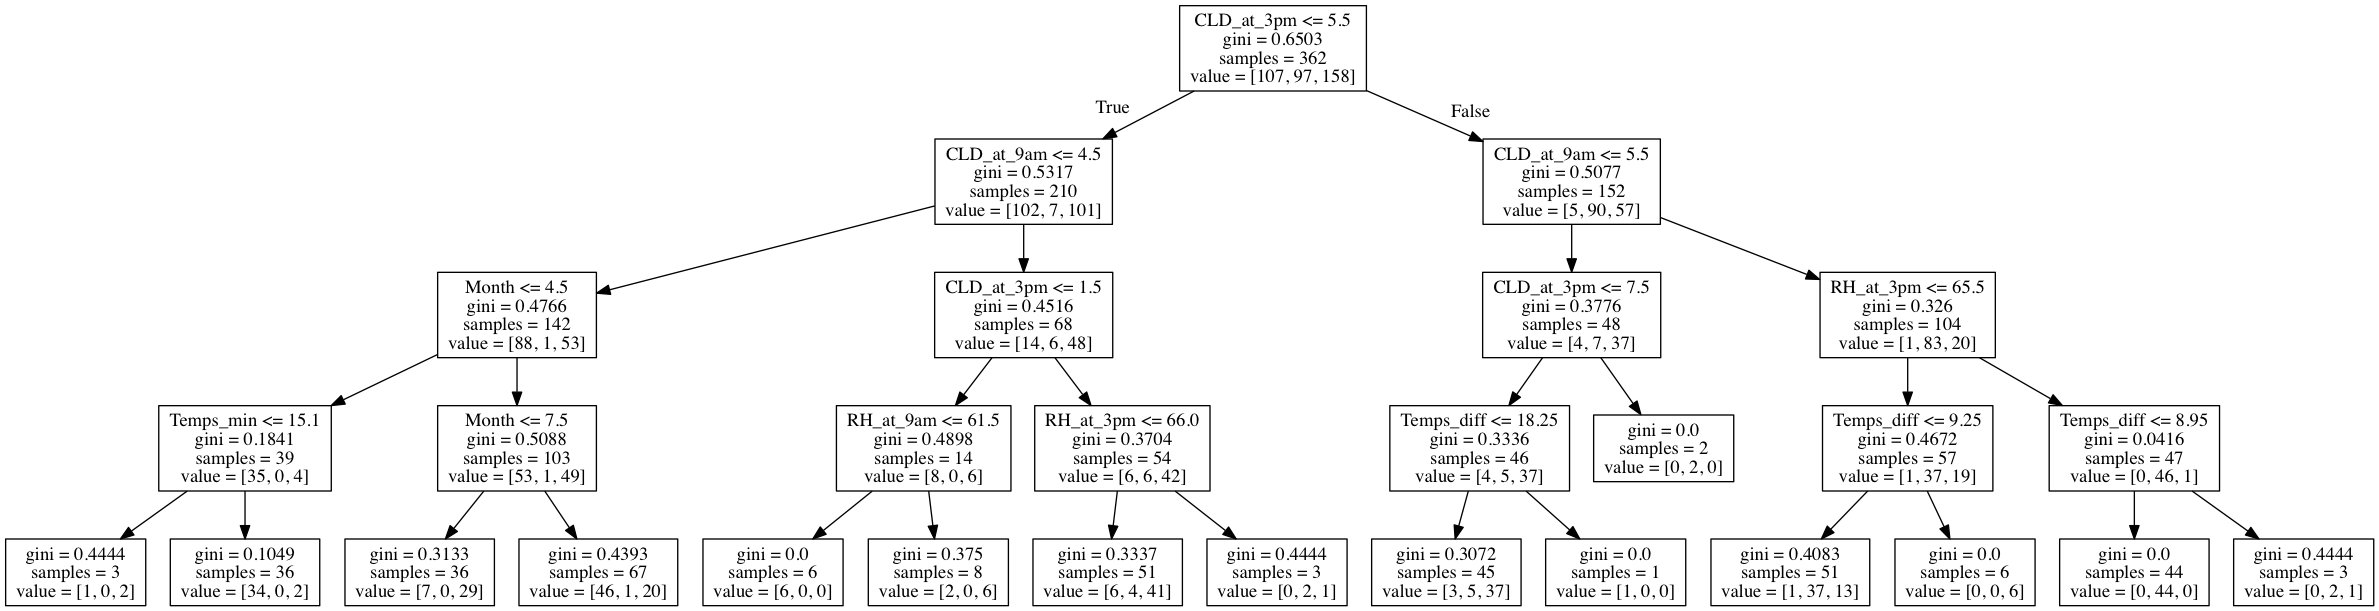

In [231]:
import pydotplus

dotfile = StringIO()
export_graphviz(dtree, out_file = dotfile, feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
Image(graph.create_png())  

You can generate a pdf file if you want

In [232]:
graph.write_pdf("./asset/dtree.pdf")

True